In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

In [2]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_n_warehouses_n_stores"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']
    if 'master_n_warehouses' in reference_row:
        out_row['master_n_warehouses'] = reference_row['master_n_warehouses']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla": "-",  # Dashed
    "GNN": "--",  # Dotted
    # "GNN_bottleneck": "-.",  # Dashed
}

# Define paths for each architecture
architectures = {
    "Vanilla": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_warehouses',
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    # "GNN_bottleneck": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_bottleneck',
}

# Define configs for different settings
configs = [
    "n_warehouse_10_2_lost_demand",
    "n_warehouse_20_3_lost_demand",
    "n_warehouse_30_4_lost_demand", 
    "n_warehouse_40_5_lost_demand", 
    "n_warehouse_50_6_lost_demand"
]

# Map configs to their (stores, warehouses) values for plotting
config_to_stores_warehouses = {
    "n_warehouse_10_2_lost_demand": (10, 2),
    "n_warehouse_20_3_lost_demand": (20, 3),
    "n_warehouse_30_4_lost_demand": (30, 4),
    "n_warehouse_40_5_lost_demand": (40, 5),
    "n_warehouse_50_6_lost_demand": (50, 6)
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_sizes = [128, 1024, 8192]

dfs = []

# Create dataframes for each architecture, passing all configs and sample sizes at once
for arch_name, path in architectures.items():
    df = results_interpretor.make_table(
        {1: path},
        {
            'train_dev_sample_and_batch_size': sample_sizes,
            'store_underage_cost': [9],
            'config': configs,
            'samples': [1]
        },
        default_condition_setter, custom_data_filler,
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by, test_loss_limit=25
    )
    if df.empty:
        continue

    df.insert(2, 'Architecture Class', arch_name)
    df.insert(1, 'hyperparam_name', arch_name)
    # Set n_stores and n_warehouses based on config
    df['n_stores'] = df['config'].map(lambda c: config_to_stores_warehouses[c][0])
    df['n_warehouses'] = df['config'].map(lambda c: config_to_stores_warehouses[c][1])
    dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

import numpy as np

test_loss_column = 'Test Loss'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) +"/"+ row['config'] + "_5000_test_loss.txt"
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

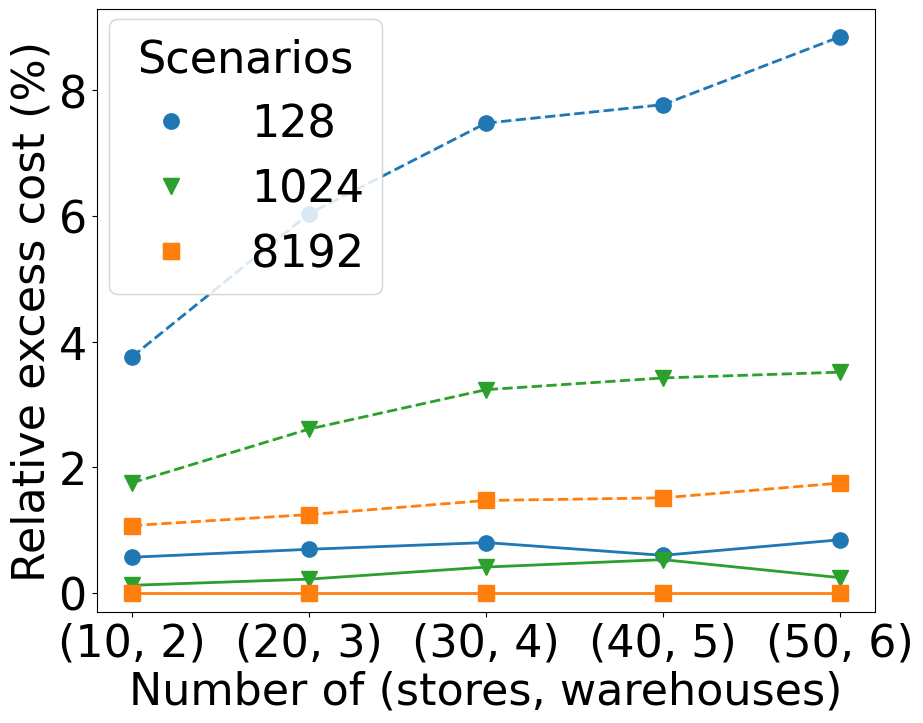

In [ ]:
# Find best test loss for each config
best_losses = {}
for config in configs:
    config_data = df[df['config'] == config]
    if not config_data.empty:
        best_losses[config] = config_data['Test Loss'].min()

# Calculate performance gap percentage
stats_by_arch_sample_and_config = {}
for config in configs:
    if config not in best_losses:
        continue
        
    best_loss = best_losses[config]
    config_data = df[df['config'] == config].copy()
    
    if config_data.empty:
        continue
        
    config_data.loc[:, 'Gap %'] = ((config_data['Test Loss'] - best_loss) / best_loss) * 100
    
    for arch in config_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_config:
                stats_by_arch_sample_and_config[key] = []
                
            sample_data = config_data[(config_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                   (config_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_config[key].append({
                    'config': config,
                    'n_stores': config_to_stores_warehouses[config][0],
                    'n_warehouses': config_to_stores_warehouses[config][1],
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

# Custom plotting parameters
FONTSIZE = 32
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Marker, color, and line style schemes
marker_scheme = {128: 'o', 1024: 'v', 8192: 's'}
color_scheme = {128: "#1f77b4", 1024: "#2ca02c", 8192: "#ff7f0e"}
linestyle_scheme = {"GNN": "-", "Vanilla": "--"}
marker_size = 11
line_width = 2

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_config.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        stats_df = stats_df.sort_values('n_stores')
        n_stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        plt.plot(
            n_stores_array, mean_gap_array,
            marker=marker_scheme[sample_size],
            color=color_scheme[sample_size],
            linestyle=linestyle_scheme[arch],
            markersize=marker_size,
            linewidth=line_width,
            label=f"{arch}, {sample_size}"
        )
        plt.fill_between(
            n_stores_array,
            ci_lower_array,
            ci_upper_array,
            color=color_scheme[sample_size],
            alpha=0.1
        )

plt.xlabel('Number of (stores, warehouses)', fontsize=FONTSIZE)
plt.ylabel('Relative excess cost (%)', fontsize=FONTSIZE)
plt.ylim(bottom=-0.3)

x_ticks = [10, 20, 30, 40, 50]
x_tick_labels = []
for n_stores in x_ticks:
    for config, (stores, warehouses) in config_to_stores_warehouses.items():
        if stores == n_stores:
            x_tick_labels.append(f"({stores}, {warehouses})")
            break
plt.xticks(x_ticks, x_tick_labels, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Legend handles: architectures (GNN above Vanilla), then sample sizes (low to high)
arch_order = ["GNN", "Vanilla"]
arch_lines = [
    plt.Line2D(
        [0], [0],
        color='gray',
        linestyle=linestyle_scheme[arch],
        linewidth=line_width,
        label=arch
    )
    for arch in arch_order
]
sample_order = [128, 1024, 8192]
sample_patches = [
    plt.Line2D(
        [0], [0],
        color=color_scheme[size],
        marker=marker_scheme[size],
        linestyle='none',
        label=f'{size}',
        markersize=marker_size
    )
    for size in sample_order
]

# legend1 = plt.legend(
#     handles=arch_lines,
#     bbox_to_anchor=(0.99, 0.75),
#     loc='upper right',
#     fontsize=FONTSIZE,
#     borderaxespad=0.1,
#     framealpha=0.6
# )
# plt.gca().add_artist(legend1)

legend2 = plt.legend(
    handles=sample_patches,
    title='Scenarios',
    # bbox_to_anchor=(0.01, 1),
    # loc='upper left',
    bbox_to_anchor=(0.01, 0.99),
    loc='upper left',
    fontsize=FONTSIZE,
    borderaxespad=0.1,
    framealpha=0.6
)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.tight_layout()
plt.savefig("/user/ml4723/Prj/NIC/Plots/sample_efficiency_MWMS.pdf", bbox_inches='tight')
plt.show()

In [21]:
import numpy as np

col_num_locations = "Number of (warehouses, stores)"
col_training_scenarios = "Training scenarios (#)"
col_arch_class = "Architecture Class"
col_lr = "Learning rate"
col_units = "Units per layer (#)"
col_train_loss = "Train loss"
col_dev_loss = "Dev loss"
col_test_loss = "Test loss"
col_rel_excess = "Relative Excess Test Loss (%)"

rows = []
for idx, row in df.iterrows():
    n_stores = row.get('n_stores', '-')
    n_warehouses = row.get('n_warehouses', '-')
    num_locations = f"({n_warehouses}, {n_stores})" if n_stores != '-' and n_warehouses != '-' else '-'
    training_scenarios = row.get('train_dev_sample_and_batch_size', '-')
    arch_class = row.get('Architecture Class', '-')
    if arch_class == "Vanilla NN":
        arch_class = "Vanilla"
    lr = row.get('Learning Rate', '-')
    units = row.get(f"master_n_warehouses", '-')
    train_loss = row.get('Train Loss', '-')
    dev_loss = row.get('Dev Loss', '-')
    test_loss = row.get('Test Loss', '-')
    rows.append({
        col_num_locations: num_locations,
        col_training_scenarios: training_scenarios,
        col_arch_class: arch_class,
        col_lr: lr,
        col_units: units,
        col_train_loss: train_loss,
        col_dev_loss: dev_loss,
        col_test_loss: test_loss,
        "n_stores": n_stores,
        "test_loss_raw": test_loss,
    })

table_df = pd.DataFrame(rows)
table_df = table_df.replace({np.nan: '-', None: '-'})

# Compute Relative Excess Test Loss (%) correctly
rel_excess_dict = {}
for num_loc in table_df[col_num_locations].unique():
    mask = table_df[col_num_locations] == num_loc
    test_losses = table_df.loc[mask, "test_loss_raw"]
    numeric_losses = pd.to_numeric(test_losses, errors='coerce')
    if numeric_losses.notna().any():
        min_loss = numeric_losses.min()
        for idx, val in zip(table_df[mask].index, numeric_losses):
            if np.isnan(val):
                rel_excess_dict[idx] = '-'
            else:
                rel_excess = 100 * (val - min_loss) / min_loss if min_loss != 0 else 0
                rel_excess_dict[idx] = round(rel_excess, 2)
    else:
        for idx in table_df[mask].index:
            rel_excess_dict[idx] = '-'
table_df[col_rel_excess] = [rel_excess_dict.get(idx, '-') for idx in table_df.index]

for col in [col_train_loss, col_dev_loss, col_test_loss]:
    def round_loss(x):
        try:
            return round(float(x), 2)
        except:
            return '-'
    table_df[col] = table_df[col].apply(round_loss)

def bold_best_test_loss(group):
    numeric_losses = pd.to_numeric(group["test_loss_raw"], errors='coerce')
    if numeric_losses.notna().any():
        min_idx = numeric_losses.idxmin()
        val = group.at[min_idx, col_test_loss]
        group.at[min_idx, col_test_loss] = f"\\textbf{{{val}}}"
    return group

table_df = table_df.groupby(col_num_locations, group_keys=False).apply(bold_best_test_loss)

table_df = table_df.drop(columns=["n_stores", "test_loss_raw"])

def arch_sort_key(arch):
    if arch == "GNN":
        return 0
    elif arch == "Vanilla":
        return 1
    else:
        return 2

def extract_n_warehouses(x):
    try:
        return int(x.split(',')[0].replace('(', '').strip())
    except:
        return 9999

table_df = table_df.copy()
table_df["_n_warehouses"] = table_df[col_num_locations].apply(extract_n_warehouses)
table_df["_training_scenarios"] = pd.to_numeric(table_df[col_training_scenarios], errors='coerce').fillna(0)
table_df["_arch_sort"] = table_df[col_arch_class].apply(arch_sort_key)
table_df = table_df.sort_values(by=["_n_warehouses", "_training_scenarios", "_arch_sort"])
table_df = table_df.drop(columns=["_n_warehouses", "_training_scenarios", "_arch_sort"])

print(table_df.to_string(index=False))

Number of (warehouses, stores)  Training scenarios (#) Architecture Class  Learning rate Units per layer (#)  Train loss  Dev loss     Test loss  Relative Excess Test Loss (%)
                       (2, 10)                     128                GNN         0.0010                   -        9.51      9.73          9.65                           0.57
                       (2, 10)                     128            Vanilla         0.0010               256.0        9.65     10.01          9.96                           3.76
                       (2, 10)                    1024                GNN         0.0010                   -        9.56      9.65          9.61                           0.12
                       (2, 10)                    1024            Vanilla         0.0010               256.0        9.67      9.80          9.77                           1.75
                       (2, 10)                    8192                GNN         0.0010                   -        9.59

/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_38858/2143123969.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{9.6}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.at[min_idx, col_test_loss] = f"\\textbf{{{val}}}"
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_38858/2143123969.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{9.4}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.at[min_idx, col_test_loss] = f"\\textbf{{{val}}}"
/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_38858/2143123969.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{9.06}' has dtype incompatible with

In [5]:
mode = "test"

gpus = [0, 1, 2, 4, 5]

def run_main_run(model_path, setting_name, gpu_idx):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for _, row in df.iterrows():
        path = str(row['path']) + '/model.pt'
        while len(futures) >= 4*len(gpus):
            done, not_done = concurrent.futures.wait(
                futures, 
                return_when=concurrent.futures.FIRST_COMPLETED
            )
            futures = list(not_done)
        futures.append(executor.submit(run_main_run, path, row['config'] + '_5000', gpu_idx))
        gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)

Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_n_warehouses_n_stores/vanilla_n_warehouses/run_2025-05-09_21-59-58/run_79db8_00294_294_config=n_warehouse_10_2_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_2025-05-10_12-02-48/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_n_warehouses_n_stores/vanilla_n_warehouses/run_2025-05-09_21-59-58/run_79db8_00249_249_config=n_warehouse_10_2_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_2025-05-10_04-26-58/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_n_warehouses_n_stores/vanilla_n_warehouses/run_2025-05-09_21-59-58/run_79db8_00069_69_config=n_warehouse_10_2_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early__2025-05-09_22-00-00/model.pt
Running main_run.py